# Fed Data Collection and Processing
---
This notebook orchestrates the scraping and processing scripts to collect data from the Federal Reserve website.


## 1. Environment Setup
- Check working directory.
- Verify that necessary directories (like `../data`) exist.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

# 设置绘图风格
sns.set(style='whitegrid', font_scale=1.2)

# 让 pandas 显示更多列
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

print("Environment setup complete.")

Environment setup complete.


## 2. Meeting Minutes
- Scrape raw HTML/PDF from the FOMC website.
- Process the text into structured sentence-level CSV files.

In [2]:
DATA_DIR = '../data/processed'

FILES = {
    'minutes': 'fed_minutes_sentences_structured.csv',
    'press': 'fed_press_conf_structured.csv',
    'speech': 'fed_speeches_sentences.csv' 
}

print(f"Data Directory set to: {os.path.abspath(DATA_DIR)}")

Data Directory set to: e:\Textming\data\processed



## 3. Speeches
- Collect transcripts of speeches from Fed officials.
- Clean and format the data.

In [3]:
def load_and_standardize(file_name, source_type):
    """
    读取 CSV, 统一列名, 并添加来源标签
    """
    path = os.path.join(DATA_DIR, file_name)
    if not os.path.exists(path):
        print(f"[Warning] File not found: {path}. Skipping...")
        return pd.DataFrame()
    
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(f"[Error] Failed to read {file_name}: {e}")
        return pd.DataFrame()
    
    # 统一列名映射
    if 'sentence_text' in df.columns:
        df = df.rename(columns={'sentence_text': 'text'})
    elif 'section_text' in df.columns:
        df = df.rename(columns={'section_text': 'text'})
    
    if 'section' not in df.columns:
        df['section'] = 'General'
        
    df['source'] = source_type
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    if df['date'].isnull().any():
        df = df.dropna(subset=['date'])

    # 确保列一致性
    if 'speaker' not in df.columns:
        df['speaker'] = 'N/A'
        
    cols = ['date', 'text', 'section', 'source', 'speaker']
    return df[cols]

## 4. Merging Datasets
- Combine all sources into a single `df_master` dataframe.


In [4]:
print("--- Loading Datasets ---")

df_minutes = load_and_standardize(FILES['minutes'], 'Minutes')
df_press = load_and_standardize(FILES['press'], 'Press Conf')
df_speech = load_and_standardize(FILES['speech'], 'Speech')

frames = [df for df in [df_minutes, df_press, df_speech] if not df.empty]

if frames:
    df_master = pd.concat(frames, ignore_index=True)
    df_master = df_master.sort_values('date').reset_index(drop=True)
    print(f"Total Raw Corpus Size: {len(df_master)} sentences")
    display(df_master.head(3))
else:
    print("[Error] No data loaded.")

--- Loading Datasets ---
Total Raw Corpus Size: 26904 sentences


,date,text,section,source,speaker
0,2018-01-31,The manager of the System Open Market Account ...,Developments in Financial Markets,Minutes,N/A
1,2018-01-31,Domestic financial market conditions eased con...,Staff Review of Financial Situation,Minutes,N/A
2,2018-01-31,A strengthening outlook for economic growth in...,Staff Review of Financial Situation,Minutes,N/A


## 5. Quality Control & Filtering
- Remove empty rows.
- Filter out "noise" (e.g., sentences shorter than 5 words that lack semantic value).


In [5]:
if 'df_master' in locals() and not df_master.empty:
    # A. 去除文本为空的行
    df_master = df_master.dropna(subset=['text'])

    # B. 噪声过滤：去除少于 5 个词的句子
    df_master['word_count'] = df_master['text'].apply(lambda x: len(str(x).split()))
    df_clean = df_master[df_master['word_count'] >= 5].copy()
    # C. 去除不包含下面关键词的行
    FED_KEYWORDS = [
    'inflation expectation', 'interest rate', 'bank rate', 'fund rate',
    'price', 'economic activity', 'inflation', 'employment',
    'unemployment', 'growth', 'exchange rate', 'productivity', 'deficit', 'demand', 'job',
    'market', 'monetary policy'
    ]
    
    df_clean = df_clean[df_clean['text'].str.contains('|'.join(FED_KEYWORDS), case=False, na=False)]    
    
    print(f"1. Dropped {len(df_master) - len(df_clean)} short/noisy sentences.")
    print(f"2. Date Range: {df_clean['date'].min().date()} to {df_clean['date'].max().date()}")
    print(f"Final Cleaned Corpus Size: {len(df_clean)} sentences")
else:
    print("No data to clean.")

1. Dropped 18607 short/noisy sentences.
2. Date Range: 2018-01-31 to 2024-12-18
Final Cleaned Corpus Size: 8297 sentences


## 6. Exploratory Data Analysis (EDA)
- Visualize the distribution of data across sources.
- Analyze sentence length distribution.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_34116\2746898593.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='source', palette='viridis')


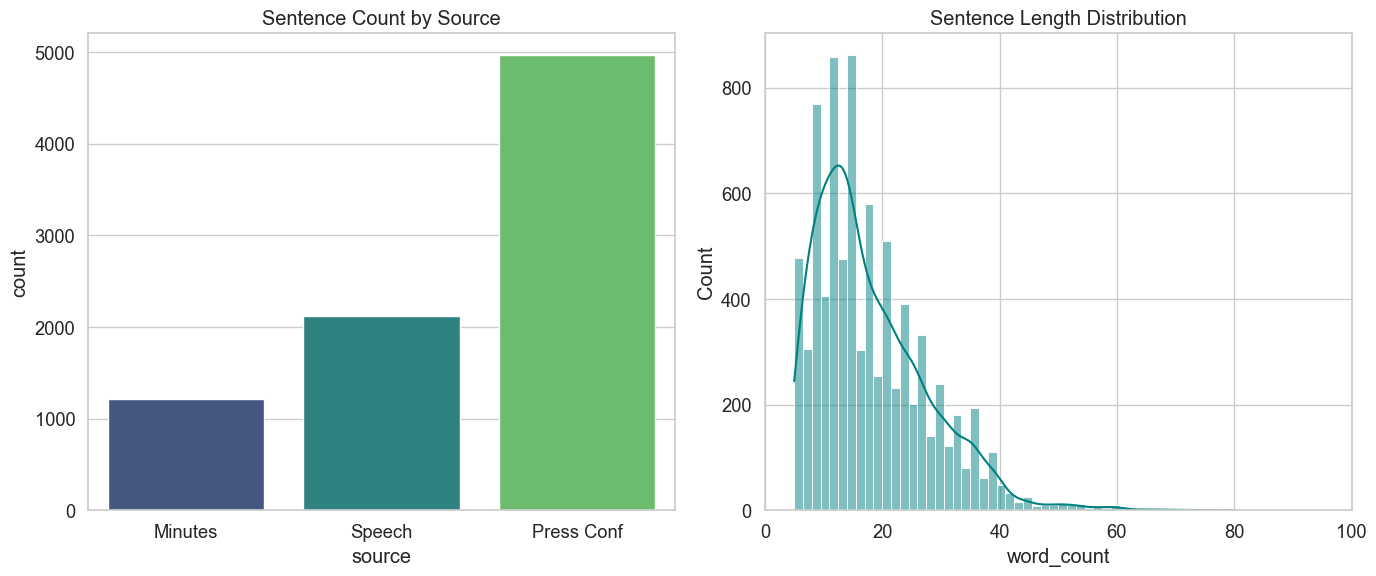

In [6]:
if 'df_clean' in locals() and not df_clean.empty:
    plt.figure(figsize=(14, 6))

    # 图1: 各类来源的数据量对比
    plt.subplot(1, 2, 1)
    sns.countplot(data=df_clean, x='source', palette='viridis')
    plt.title('Sentence Count by Source')

    # 图2: 句子长度分布
    plt.subplot(1, 2, 2)
    sns.histplot(df_clean['word_count'], bins=50, kde=True, color='teal')
    plt.title('Sentence Length Distribution')
    plt.xlim(0, 100)

    plt.tight_layout()
    plt.show()

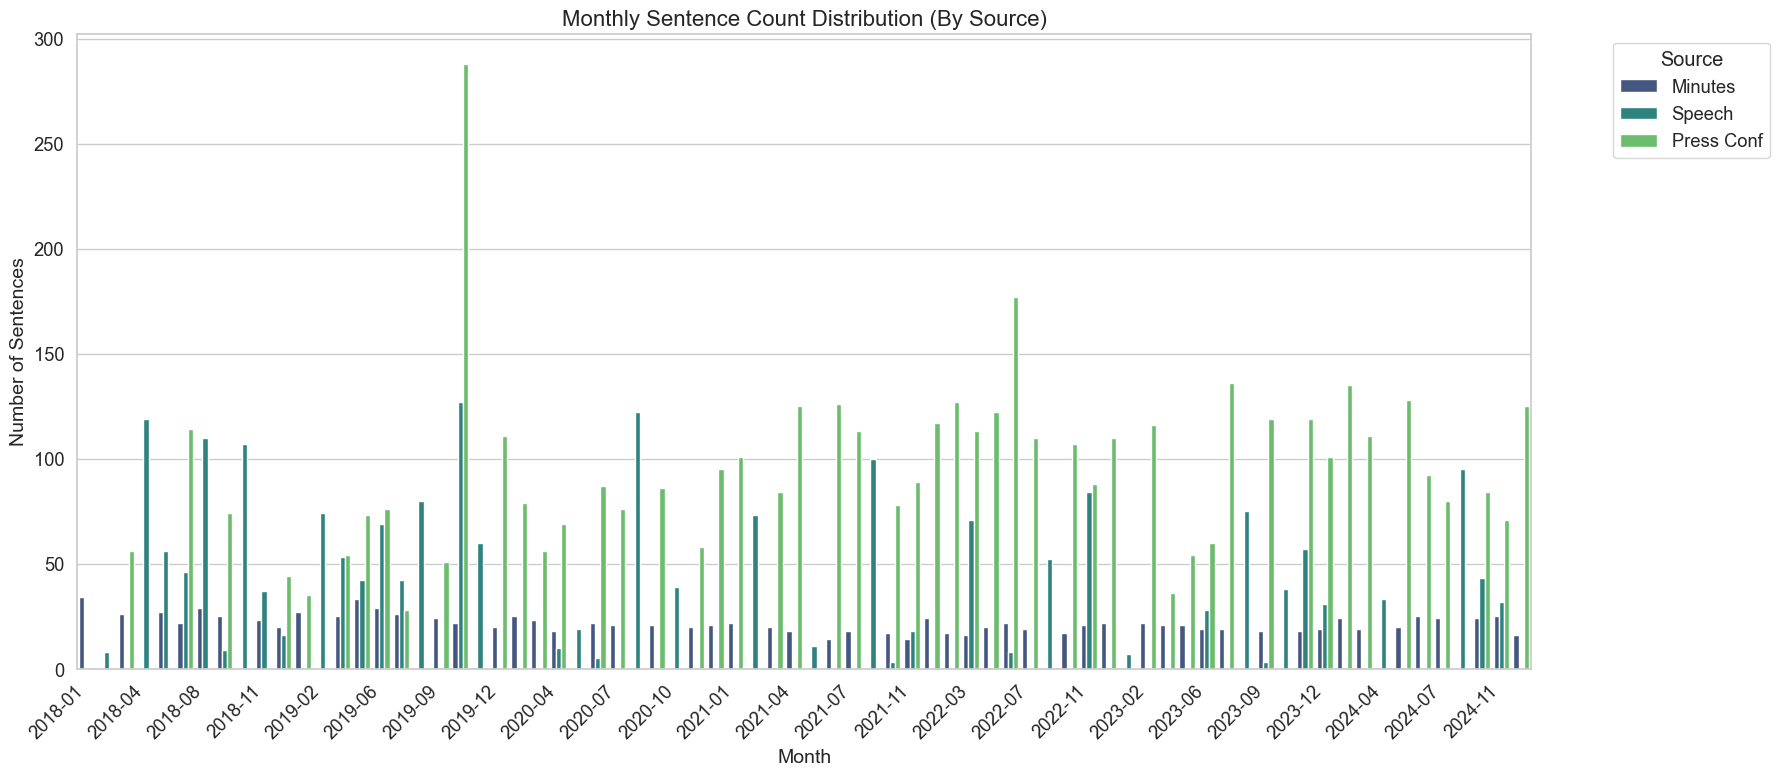

--- Temporal Coverage Stats ---
Start Date: 2018-01-31
End Date:   2024-12-18
Total Months Covered: 74
Peak Activity Month: 2019-10 (Total 437 sentences)


In [7]:
# ==========================================
# Monthly Sentence Count Visualization
# ==========================================

if 'df_clean' in locals() and not df_clean.empty:
    # 1. 创建一个新的列 'month_year' 用于按月聚合
    # 将日期转换为 'YYYY-MM' 格式的 Period 对象，方便排序
    df_clean['month_year'] = df_clean['date'].dt.to_period('M')

    # 2. 按 'month_year' 和 'source' 分组统计句子数量
    monthly_counts = df_clean.groupby(['month_year', 'source']).size().reset_index(name='count')

    # 3. 将 'month_year' 转回字符串或 Timestamp 以便绘图
    monthly_counts['month_year_str'] = monthly_counts['month_year'].astype(str)
    
    # 设置绘图尺寸
    plt.figure(figsize=(18, 8))

    # 4. 绘制柱状图 (Barplot)
    # hue='source' 会自动按 Minutes, Press Conf, Speech 分不同颜色显示
    ax = sns.barplot(
        data=monthly_counts, 
        x='month_year_str', 
        y='count', 
        hue='source',
        palette='viridis'
    )

    # 5. 美化图表
    plt.title('Monthly Sentence Count Distribution (By Source)', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Number of Sentences', fontsize=14)
    plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')

    # 优化 X 轴标签：如果月份太多，标签会挤在一起
    # 我们只显示每隔 3 个月的标签，并旋转 45 度
    x_labels = monthly_counts['month_year_str'].unique()
    # 重新设置 ticks
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # 减少显示的标签数量 (每隔 n 个显示一个)
    n = 3  # 每 3 个月显示一次标签
    for i, label in enumerate(ax.xaxis.get_ticklabels()):
        if i % n != 0:
            label.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    # 打印一些统计信息，帮助你写 Report
    print("--- Temporal Coverage Stats ---")
    print(f"Start Date: {df_clean['date'].min().date()}")
    print(f"End Date:   {df_clean['date'].max().date()}")
    print(f"Total Months Covered: {df_clean['month_year'].nunique()}")
    
    # 找出数据量最大的月份 (Peak Month)
    peak_month = monthly_counts.groupby('month_year')['count'].sum().idxmax()
    peak_count = monthly_counts.groupby('month_year')['count'].sum().max()
    print(f"Peak Activity Month: {peak_month} (Total {peak_count} sentences)")

else:
    print("DataFrame 'df_clean' is empty or not defined. Please run the previous cells first.")

## 7. Exporting the Master Corpus
- Save the final cleaned dataset to `fed_master_corpus.csv` for downstream NLP tasks.

In [8]:
if 'df_clean' in locals() and not df_clean.empty:
    data_root = os.path.dirname(DATA_DIR)
    output_path = os.path.join(data_root, 'master','fed_master_corpus.csv')
    
    # 使用 utf-8-sig 编码以防 Excel 打开乱码
    df_clean.to_csv(output_path, index=False, encoding='utf-8-sig', quoting=csv.QUOTE_ALL)

    print(f"[Success] Master Corpus saved to: {os.path.abspath(output_path)}")
    print(f"Final Shape: {df_clean.shape}")
else:
    print("Skipping save because dataframe is empty.")

[Success] Master Corpus saved to: e:\Textming\data\master\fed_master_corpus.csv
Final Shape: (8297, 7)


--- Starting Content Analysis ---
Tokenizing Minutes...
Tokenizing Press Conference...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_34116\3140696946.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs_m), y=list(words_m), ax=axes[0], palette="Blues_d")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_34116\3140696946.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs_p), y=list(words_p), ax=axes[1], palette="Greens_d")


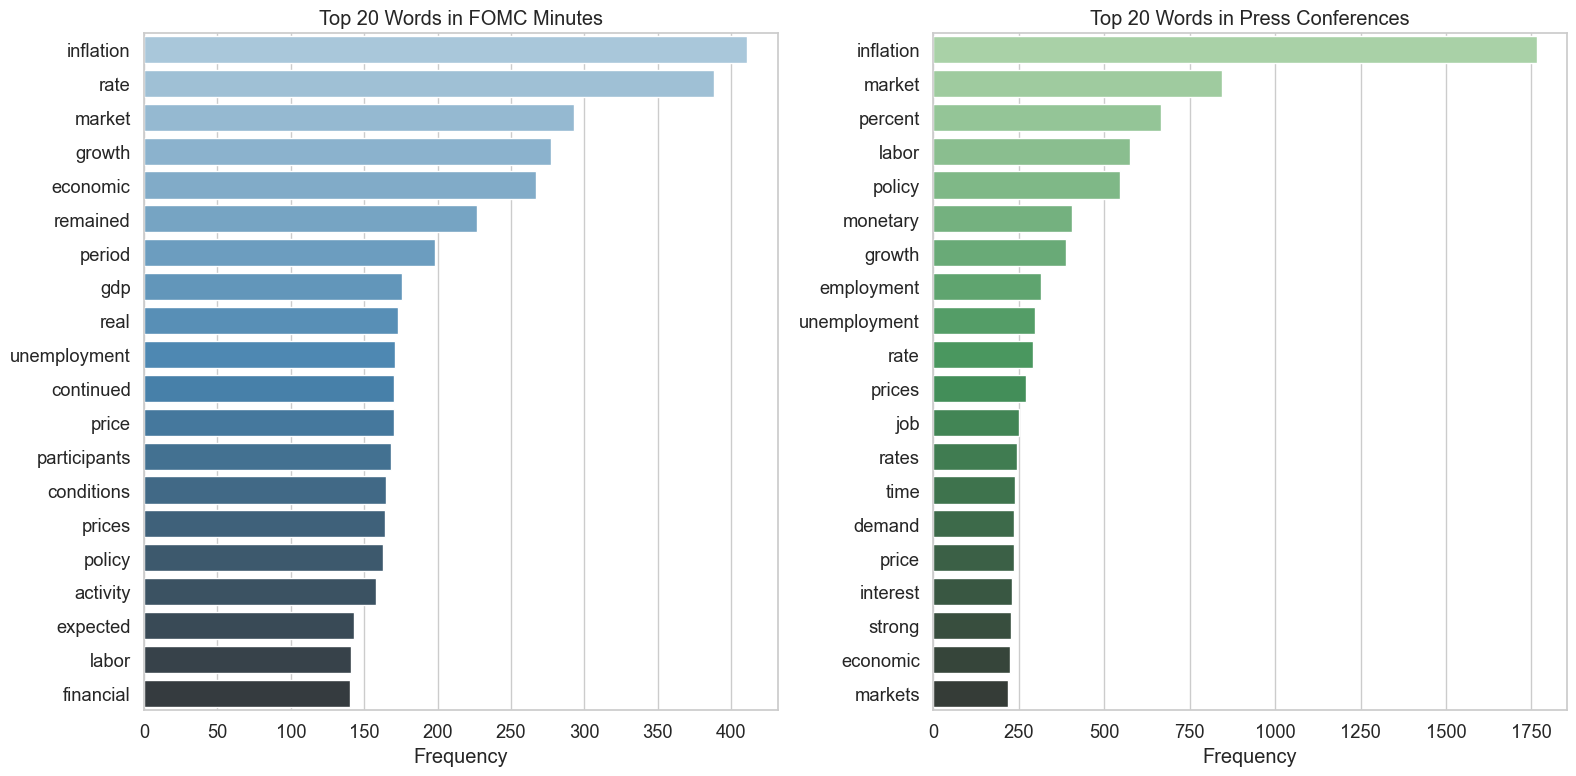

Generating Bigrams...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_34116\3140696946.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs_m, y=words_m, ax=axes[0], palette="Blues_d")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_34116\3140696946.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=freqs_p, y=words_p, ax=axes[1], palette="Greens_d")


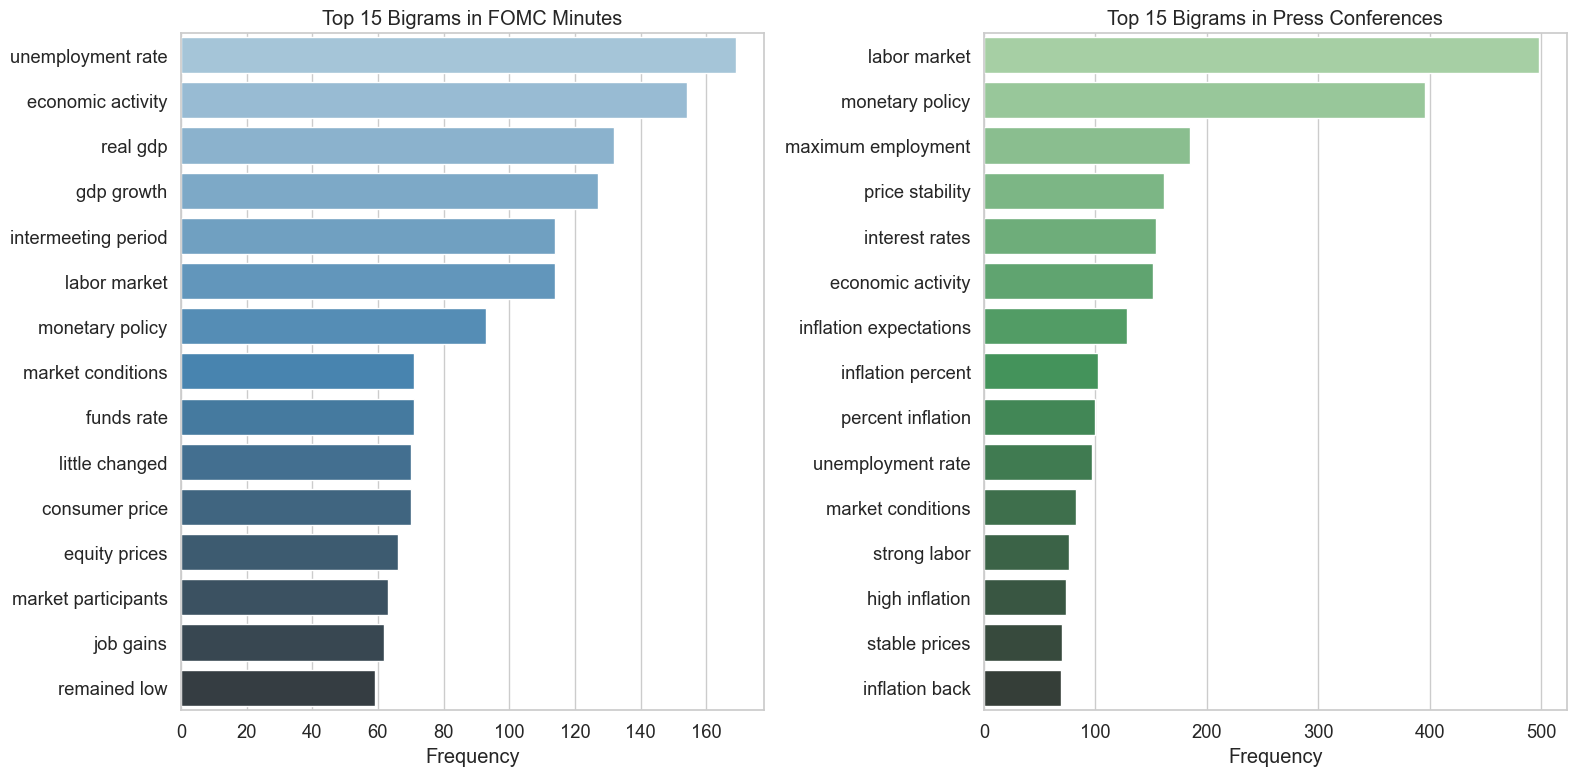

In [9]:
from collections import Counter
# Removed WordCloud import as per project guidelines
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re

# 确保下载了停用词
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# ==========================================
# 4. 文本内容分析 (Content Analysis)
# ==========================================

print("--- Starting Content Analysis ---")

# A. 预处理：构建停用词表
# 除了标准的英文停用词，我们还需要去除美联储特有的“废话”
stop_words = set(stopwords.words('english'))
custom_stops = {
    'thank', 'think', 'going', 'would', 'could', 'chair', 'chairman', 'powell',
    'mr', 'ms', 'question', 'well', 'say', 'committee', 'federal', 'reserve',
    'meeting', 'us', 'year', 'months', 'see', 'one', 'two', 'much'
}
stop_words.update(custom_stops)

def get_tokens(text_series):
    """将文本序列转换为清洗后的单词列表"""
    all_text = " ".join(text_series.astype(str))
    # 转小写，去标点
    all_text = re.sub(r'[^a-zA-Z\s]', '', all_text.lower())
    tokens = all_text.split()
    # 去停用词
    clean_tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return clean_tokens

# B. 计算词频
# 分别计算 Minutes 和 Press Conf 的高频词
print("Tokenizing Minutes...")
tokens_minutes = get_tokens(df_clean[df_clean['source'] == 'Minutes']['text'])
print("Tokenizing Press Conference...")
tokens_press = get_tokens(df_clean[df_clean['source'] == 'Press Conf']['text'])

# 统计 Top 20
count_minutes = Counter(tokens_minutes).most_common(20)
count_press = Counter(tokens_press).most_common(20)

# C. 绘制对比柱状图 (Alternative to Word Cloud)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Minutes Top 20
words_m, freqs_m = zip(*count_minutes)
sns.barplot(x=list(freqs_m), y=list(words_m), ax=axes[0], palette="Blues_d")
axes[0].set_title('Top 20 Words in FOMC Minutes')
axes[0].set_xlabel('Frequency')

# Press Conf Top 20
words_p, freqs_p = zip(*count_press)
sns.barplot(x=list(freqs_p), y=list(words_p), ax=axes[1], palette="Greens_d")
axes[1].set_title('Top 20 Words in Press Conferences')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

# ==========================================
# 5. [Optional] N-Grams Analysis (Bigrams)
# ==========================================
# Instead of Word Clouds, N-Grams provide more context (e.g. "interest rate" vs "rate")

from nltk.util import ngrams

def get_bigrams(tokens):
    return list(ngrams(tokens, 2))

print("Generating Bigrams...")
bigrams_minutes = get_bigrams(tokens_minutes)
bigrams_press = get_bigrams(tokens_press)

count_bigrams_m = Counter(bigrams_minutes).most_common(15)
count_bigrams_p = Counter(bigrams_press).most_common(15)

# Plot Bigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Minutes Bigrams
words_m = [" ".join(w) for w, f in count_bigrams_m]
freqs_m = [f for w, f in count_bigrams_m]
sns.barplot(x=freqs_m, y=words_m, ax=axes[0], palette="Blues_d")
axes[0].set_title('Top 15 Bigrams in FOMC Minutes')
axes[0].set_xlabel('Frequency')

# Press Conf Bigrams
words_p = [" ".join(w) for w, f in count_bigrams_p]
freqs_p = [f for w, f in count_bigrams_p]
sns.barplot(x=freqs_p, y=words_p, ax=axes[1], palette="Greens_d")
axes[1].set_title('Top 15 Bigrams in Press Conferences')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()